# **Context**

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from copy import copy
import cv2

from tqdm import tqdm
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%matplotlib inline

import albumentations as A

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
sns.set_style('whitegrid')

Cell for Google Colab training:

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# !unzip -q /content/gdrive/MyDrive/Machine_Learning/Projects/Spacer/people_segmentation.zip

Mounted at /content/gdrive/


Cells for local training:

In [3]:
import zipfile

with zipfile.ZipFile('../background_removal/people_segmentation.zip') as zip_file:
    zip_file.extractall()

In [4]:
# Checking if GPU is avaliable
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print('GPU availiable:', torch.cuda.is_available())

GPU availiable: True


In [5]:
# Initializing normalization parameters
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

## **Defining some useful functions**

In [6]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    '''
    A function to evaluate model's performance.
    '''
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return (thresholded.sum() / len(outputs)).item()

In [7]:
def imshow_tensor(inp, plt_ax=plt, mean=mean,
           std=std):
    '''
    A function for displaying image in tensor format.
    '''
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt_ax.grid(False)

In [8]:
def display_images(images_dir: str, masks_dir: str, num_images=5):
    '''
    A function for displaying multiple images.
    '''
    num_images = num_images

    fig, ax = plt.subplots(2, num_images, figsize=(20, 6),
                        sharey=True, sharex=True)

    ax[0][0].annotate('Image', (-0.25, 0.5), xycoords='axes fraction', rotation=90,
                    va='center', fontweight='bold', fontsize=12)
    ax[1][0].annotate('Target mask', (-0.25, 0.5), xycoords='axes fraction', rotation=90,
                    va='center', fontweight='bold', fontsize=12)

    for index in range(num_images):
        # Choose a random image index
        random_image_idx = np.random.randint(0, len(os.listdir(images_dir)))

        image_path = sorted(os.listdir(images_dir))[random_image_idx]
        image = Image.open(os.path.join(images_dir, image_path)).convert('RGB').resize((320, 320))
        image.load()

        mask_path = sorted(os.listdir(masks_dir))[random_image_idx]
        mask = Image.open(os.path.join(masks_dir, mask_path)).resize((320, 320))
        mask.load()

        # Convert to array
        image = np.array(image)
        mask = np.array(mask)

        # Draw an image
        ax[0][index].imshow(image)
        ax[0][index].axis('off')

        # Draw a corresponding mask
        ax[1][index].imshow(mask)
        ax[1][index].axis('off')

# **Data preprocessing**

## **Getting list of filenames**

Images and masks for training and validations are contained in the same folders. To form a train and a validation datasets, we need to get the names of files that belong to each of these datasets.

Names of corresponding files are located in 'segmentation' folder('train.txt' and 'val.txt' files).

In [9]:
# Get train and val filenames
root = 'people_segmentation/segmentation'
for _, _, filenames in os.walk(root):
    for filename in filenames:
        if filename == 'train.txt':
            with open(os.path.join(root, filename)) as f:
                train_files = f.read().split()
        elif filename == 'val.txt':
            with open(os.path.join(root, filename)) as f:
                val_files = f.read().split()

print('# of train files:', len(train_files))
print('# of val files:', len(val_files))

# of train files: 5110
# of val files: 568


In [10]:
# Make directories for the train and val files
if os.path.exists('people_segmentation/train'):
    shutil.rmtree('people_segmentation/train')
os.mkdir('people_segmentation/train')

if os.path.exists('people_segmentation/val'):
    shutil.rmtree('people_segmentation/val')
os.mkdir('people_segmentation/val')

## **Moving images and masks to 'train' and 'val' folders**

In [11]:
def move_data_to_folders(files: list, mode: str):
    '''
    A function to move train/val images and masks to corresponding folders.
    '''
    # Make a check if mode is correct
    if mode not in ['train', 'val']:
        raise ValueError('Incorrect mode! Use "train" or "val" instead!')

    # Define path to a dataset
    main_dir = 'people_segmentation'

    for item in ['images', 'masks']:
        # Create folder for corresponding items
        item_dir_path = os.path.join(main_dir, mode, item)
        if os.path.exists(item_dir_path):
            shutil.rmtree(item_dir_path)
        os.mkdir(item_dir_path)

        # Move items to a corresponding folder
        for root, _, filenames in os.walk(main_dir):
            if root == os.path.join(main_dir, item):
                for filename in filenames:
                    curr = os.path.join(root, filename)
                    if filename.split('.')[0] in files:
                        shutil.copy(curr, os.path.join(item_dir_path, filename))

In [12]:
# Move files to corresponding folders
move_data_to_folders(train_files, 'train')
move_data_to_folders(val_files, 'val')

Let's visualize some images and their masks.

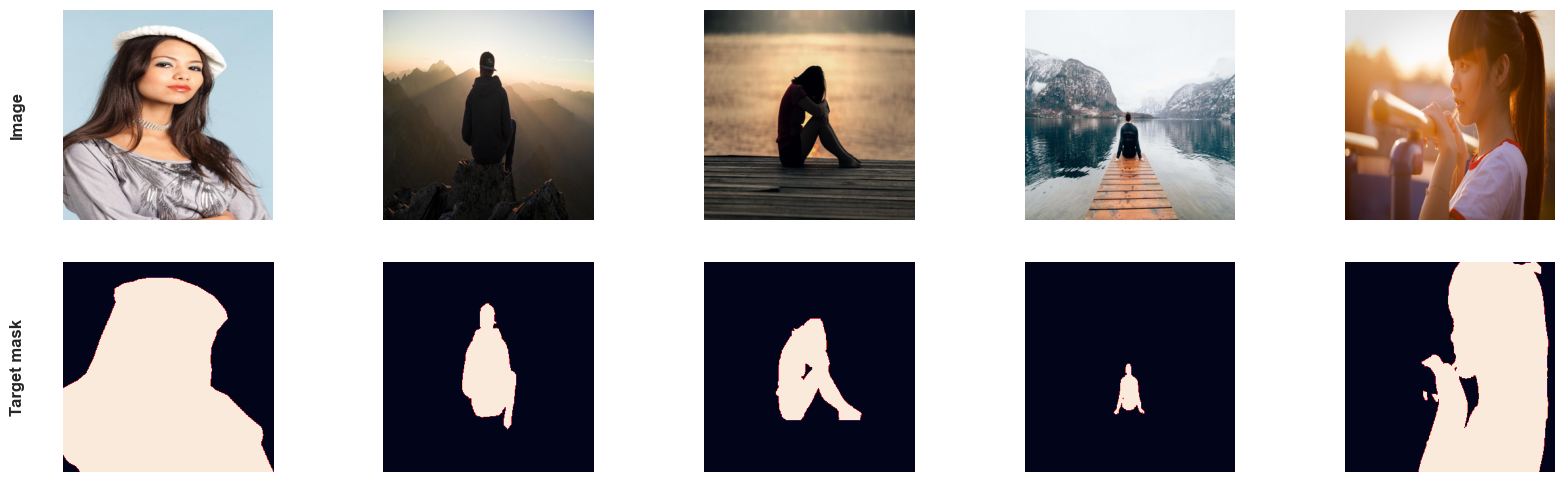

In [13]:
images_dir = 'people_segmentation/train/images'
masks_dir = 'people_segmentation/train/masks'

display_images(images_dir, masks_dir)

## **Augmenting the training dataset**

Let's augment a portion of the training dataset. We will randomly select a portion of images from the training set and perform random augmentations on each of them. After that, we will store the augmented portion of a dataset + original dataset in a new folder.

This way we will try to increase the amount and variety of availiable data. So that model will be less prone to overfitting. Which should lead to a better performance.

In [14]:
def augment_image_and_mask(image_path, mask_path, augmentation):
    # Download the image and mask
    image = Image.open(image_path).convert('RGB')
    image.load()
    mask = Image.open(mask_path)
    mask.load()

    # Convert to array (necessary for Albumentations)
    image = np.array(image)
    mask = np.array(mask)

    # Make mask match image shape (necessary for Albumentations)
    mask = np.repeat(mask[ :, :, np.newaxis], 3, axis=2)

    # Augment image and mask
    image, mask = augmentation(image=image, mask=mask).values()

    # Return mask to initial shape
    mask = mask[:, :, 0]

    return image, mask

Note: variable 'train_files' was defined earlier and consists of all the names of files in train dataset.

In [15]:
# Determine a portion of the dataset to augment
portion = 0.8

# Determine the number of samples to augment
num_augmented = int(np.round(len(train_files) * portion))

# Randomly select determined number of samples
idx_augmented = np.random.randint(0, len(train_files), num_augmented)
files_augmented = [train_files[idx] for idx in idx_augmented]

assert num_augmented == len(files_augmented), '# items to choose != # of chosen items'

In [16]:
# Create folder for the augmented images and copy train files there
if not os.path.exists('people_segmentation/train/augmented_images'):
    shutil.copytree('people_segmentation/train/images', 'people_segmentation/train/augmented_images')

# Create folder for the augmented masks and copy train files there
if not os.path.exists('people_segmentation/train/augmented_masks'):
    shutil.copytree('people_segmentation/train/masks', 'people_segmentation/train/augmented_masks')

In [17]:
# Define augmentation settings
augment = A.Compose([
    A.OneOf([A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5)
             ], p=0.7),
    A.OneOf([A.HorizontalFlip(p=0.5),
             A.Transpose(p=0.5)
             ], p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=180, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
])

In [18]:
for f in files_augmented:
    # Get the image and mask names
    image_name = f'{f}.jpg'
    mask_name = f'{f}.png'

    # Get the path to image and mask
    image_path = os.path.join('people_segmentation/train/augmented_images',
                            image_name)
    mask_path = os.path.join('people_segmentation/train/augmented_masks',
                            mask_name)

    # Download and augment image and mask
    image, mask = augment_image_and_mask(image_path, mask_path, augment)

    # Convert image and mask to PIL format
    image = Image.fromarray(image)
    mask = Image.fromarray(mask)

    # Save augmented image and mask to corresponding directories
    image.save(f'people_segmentation/train/augmented_images/augmented_{image_name}', 'JPEG')
    mask.save(f'people_segmentation/train/augmented_masks/augmented_{mask_name}', 'PNG')

Let's visualize some images and masks from the augmented dataset.

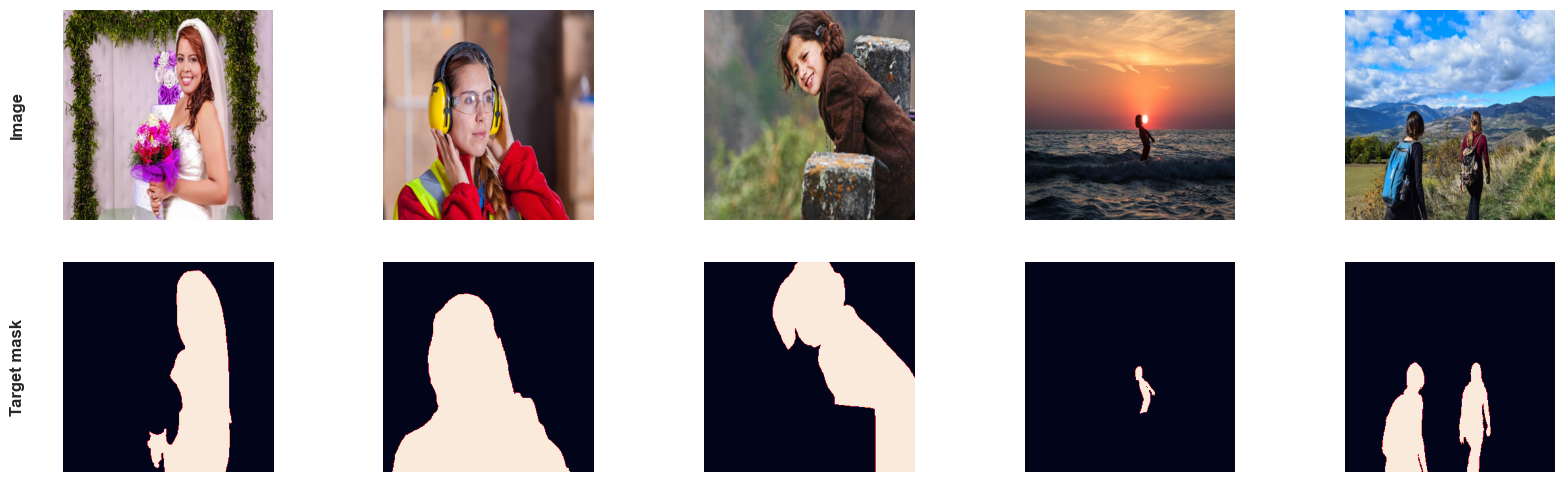

In [19]:
images_dir = 'people_segmentation/train/augmented_images'
masks_dir = 'people_segmentation/train/augmented_masks'

display_images(images_dir, masks_dir)

## **Building a PyTorch dataloaders**

In [20]:
class SegmentationDataset(Dataset):
    '''
    A dataset class to download images and masks directly from folders.
    '''
    def __init__(self, image_files, mask_files, rescale_size,
                 mean=mean, std=std):
        super().__init__()

        # List of image files
        self.image_files = sorted(image_files)

        # List of mask files
        self.mask_files = sorted(mask_files)

        # Rescale size value
        self.rescale_size = rescale_size

        assert len(self.image_files) == len(self.mask_files),\
         '# of images != # of masks, something is wrong'

        # Length of a dataset
        self.len_ = len(self.image_files)

        # Normalization parameters
        self.mean = mean
        self.std = std

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # Images transformation, normalization and loading
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)
        ])
        # We need to make sure that all images are in rgb
        x = self.load_sample(self.image_files[index]).convert('RGB')
        x = self._prepare_sample(x)
        x = transform(x)

        # Mask loading
        y = self.load_sample(self.mask_files[index])
        y = self._prepare_sample(y)
        return x, y

    def _prepare_sample(self, image):
        image = image.resize((self.rescale_size, self.rescale_size))
        return np.array(image)

In [21]:
def get_dataloader(image_files: list, mask_files: list,
                   rescale_size: int, batch_size: int, shuffle: bool):
    '''
    Function to initialize a dataloader.
    '''
    # Initializing the dataset class instance
    dataset = SegmentationDataset(image_files, mask_files, rescale_size)

    # Initialize dataloader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [22]:
def get_filepaths(dir_path: str):
    filepaths = []
    for f in os.listdir(dir_path):
        filepath = os.path.join(dir_path, f)
        filepaths.append(filepath)
    return filepaths

In [23]:
# Get full paths to images and masks
train_images_dir = get_filepaths('people_segmentation/train/augmented_images')
train_masks_dir = get_filepaths('people_segmentation/train/augmented_masks')

val_images_dir = get_filepaths('people_segmentation/val/images')
val_masks_dir = get_filepaths('people_segmentation/val/masks')

In [24]:
# Initialize the dataloaders
train_loader = get_dataloader(train_images_dir, train_masks_dir, rescale_size=128,
                                  batch_size=64, shuffle=True)
val_loader = get_dataloader(val_images_dir, val_masks_dir, rescale_size=128,
                                  batch_size=64, shuffle=False)

# **Model building**

We will focus on implementing and training the model of UNet architecture.

One of the distinc features of UNet is "double convolution". Let's make the DoubleConv class that implements this idea.

In [25]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):

        return self.conv(x)

Implementing the UNet model class.

In [26]:
class UNet(nn.Module):
    '''
    UNet neural network class.

    in_channels - number of channels in imput images.
    out_classes - number of channels for output mask.
    features - each number adds a layer with corresponding number of channels in down and up part.
    '''
    def __init__(
            self, in_channels=3, out_channels=1, features=(32, 64, 128, 256),
    ):
        super(UNet, self).__init__()
        # Creating module lists for layers so we can call them
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Performing the downsampling
        for down in self.downs:
            x = down(x)
            # Saving the skip connections
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Reversing the list,
        # because we will feed skip connections starting from the last one
        skip_connections = skip_connections[::-1]

        # Performing the upsampling
        for idx in range(0, len(self.ups), 2):
            # Feed data to Transpose Conv layer
            x = self.ups[idx](x)
            # Add the corresponding skip connection
            skip_connection = skip_connections[idx//2]

            # Concatenating the skip connection
            concat_skip = torch.cat((skip_connection, x), dim=1)
            # Feeding the result to the Double Conv layer
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# **Defining fit, eval and train functions**

In [27]:
def visualize_training(train_history, val_history):
    '''
    Function to visualize the results of a model training.
    '''
    # Plot loss graph
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_title('Loss graph')
    ax[0].set_xlabel('Epochs')
    ax[0].plot(train_history['loss'], label='train_loss')
    ax[0].plot(val_history['loss'], label='val_loss')

    # Plot IoU graph
    ax[1].set_title('IoU graph')
    ax[1].set_xlabel('Epochs')
    ax[1].plot(train_history['metric'], label='train_IoU')
    ax[1].plot(val_history['metric'], label='val_IoU')

    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    plt.show()

In [28]:
def upload_history(history_dir: str):
    '''
    A function to upload history. This way we are keeping track of all the training done.
    '''
    train_history_path = os.path.join(history_dir, 'train_history.csv')
    if os.path.exists(train_history_path):
        train_history = pd.read_csv(train_history_path)
    else:
        train_history = pd.DataFrame(columns=['loss', 'metric'])
        train_history.to_csv(train_history_path, index=False)

    val_history_path = os.path.join(history_dir, 'val_history.csv')
    if os.path.exists(val_history_path):
        val_history = pd.read_csv(val_history_path)
    else:
        val_history = pd.DataFrame(columns=['loss', 'metric'])
        val_history.to_csv(val_history_path, index=False)
    return train_history, val_history

In [29]:
def load_model(model_path: str):
    global model
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    for f in os.listdir(model_path):
        if f.endswith(".pt"):
            model.load_state_dict(torch.load(os.path.join(model_path, f)))
    train_history, val_history = upload_history(model_path)
    return train_history, val_history

In [30]:
def fit_epoch( model, loader, criterion, optimizer):
    loop = tqdm(loader)

    epoch_loss = 0
    epoch_iou = 0

    model.train()

    for data, target in loop:
        # Clear gradients
        optimizer.zero_grad()

        # Get the sample data and target
        data = data.to(device=device)
        target = target.float().unsqueeze(1).to(device=device)

        # Batch logits and predictions
        logits = model(data)
        predictions = torch.sigmoid(logits) > 0.5

        # Batch loss and metric
        loss = criterion(logits, target)
        iou = iou_pytorch(predictions, target)

        # Train epoch loss and metric
        epoch_loss += loss.item() / len(loader)
        epoch_iou += iou / len(loader)

        # Backprop
        loss.backward()
        optimizer.step()

        loop.set_postfix(batch_loss=np.round(loss.item(), decimals=3),
                         batch_iou=np.round(iou, decimals=3))

    return np.round(epoch_loss, decimals=3), np.round(epoch_iou, decimals=3)

In [31]:
def eval_epoch(model, loader, criterion):
    epoch_loss = 0
    epoch_iou = 0

    model.eval()

    for data, target in loader:
        data = data.to(device=device)
        target = target.float().unsqueeze(1).to(device=device)

        with torch.no_grad():
            # Batch logits and predictions
            logits = model(data)
            predictions = torch.sigmoid(logits) > 0.5

            # Batch loss and metric
            loss = criterion(logits, target)
            iou = iou_pytorch(predictions, target)

        # Val epoch loss and metric
        epoch_loss += loss.item() / len(loader)
        epoch_iou += iou / len(loader)

    return np.round(epoch_loss, decimals=3), np.round(epoch_iou, decimals=3)

In [32]:
def train(model, train_loader, val_loader, criterion, optimizer,
          train_history, val_history, epochs=5):
    '''
    Function to train a model and save the best one.
    '''
    # History tracking initialization
    train_history, val_history = train_history, val_history

    # Initial values for best model selection
    best_model = copy(model.state_dict())
    best_iou = 0.0

    # Early stoppage criterion initialization
    count = 0

    for epoch in range(epochs):
        print('Epoch:', len(train_history.index))

        # Restarting the trigger
        best_model_updated = False

        # Training part of epoch
        train_loss, train_iou = fit_epoch(model, train_loader, criterion, optimizer)

        # Validation part of epoch
        val_loss, val_iou = eval_epoch(model, val_loader, criterion)

        # Early stoppage criterion check and best model update
        if val_iou <= best_iou:
            count += 1
            if count >= 5:
                break
        else:
            # Refresh early stoppage criterion
            count = 0

            # Update the best model
            best_model = copy(model.state_dict())
            best_iou = val_iou
            best_model_updated = True

        # Epoch stats
        clear_output(wait=True)
        print('Epoch:', len(train_history.index))
        print('Train loss:', np.round(train_loss, decimals=3))
        print('Train IoU:', np.round(train_iou, decimals=3))
        print('Validation loss:', np.round(val_loss, decimals=3))
        print('Validation IoU:', np.round(val_iou, decimals=3))
        print('Best model updated:', best_model_updated)

        # Updating the training history
        train_history.loc[len(train_history.index)] = [train_loss, train_iou]
        val_history.loc[len(val_history.index)] = [val_loss, val_iou]

        # Visualization of training process
        visualize_training(train_history, val_history)

        # Making a checkpoint
        root = 'UNet_versions_128p'
        if len(train_history.index) % 5 == 0:
            model_dir = os.path.join(root, f'UNet_epoch_{len(train_history.index)}')
            if os.path.exists(model_dir):
                shutil.rmtree(model_dir)
            os.mkdir(model_dir)
            torch.save(model.state_dict(), os.path.join(model_dir, f'UNet_epoch_{len(train_history.index)}.pt'))

            # Saving the training history
            train_history.to_csv(os.path.join(model_dir, 'train_history.csv'), index=False)
            val_history.to_csv(os.path.join(model_dir, 'val_history.csv'), index=False)

    return train_history, val_history, best_model

In [33]:
def predict_one_sample(model, image_path, resize_scale,
                       mean=mean, std=mean):
    # Loading sample
    image = Image.open(image_path)
    image.load()

    # Resize and convert to numpy
    image = np.array(image.resize((resize_scale, resize_scale)))

    # Transform sample
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])
    image = transform(image)

    # Make prediction
    logits = model(image[None, :, :, :].to(device)).squeeze((0, 1)).cpu().detach()
    preds = torch.sigmoid(logits) > 0.5

    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       sharey=True, sharex=True)

    # Draw an image
    imshow_tensor(image, plt_ax=ax[0])
    ax[0].axis('off')

    # Draw a predicted mask
    mask = np.repeat(preds[np.newaxis, :, :], 3, axis=0)
    segmented_image = torch.Tensor(np.where(mask, image, 0))
    imshow_tensor(segmented_image, plt_ax=ax[1])
    ax[1].axis('off')

    return preds

# **Model training**

In [34]:
# Initializing the model
model = UNet().to(device)

In [45]:
# Loading the model
model_path = 'UNet_versions_128p/UNet_epoch_20'
train_history, val_history = load_model(model_path)

In [46]:
# Initializing the loss function, optimizer
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

Epoch: 29
Train loss: 87362.074
Train IoU: 0.695
Validation loss: 176798.545
Validation IoU: 0.61
Best model updated: False


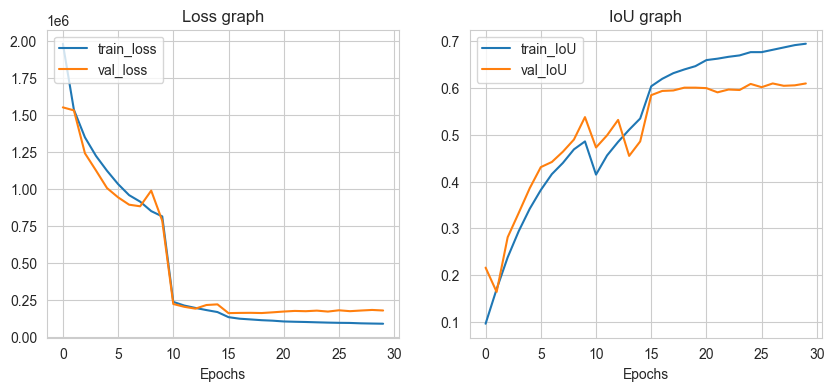

In [48]:
# Training the model
train_history, val_history, best_model = train(model, train_loader, val_loader,
                                               criterion, optimizer, epochs=5,
                                               train_history=train_history, val_history=val_history)

In [50]:
# Saving the best model
torch.save(best_model, 'UNet_versions_128p/UNet_best.pt')

In [48]:
import gc

gc.collect()
torch.cuda.empty_cache()

# **Testing the model**




In [52]:
# Loading the model
model_path = 'UNet_versions_128p/UNet_best.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**Test 1**

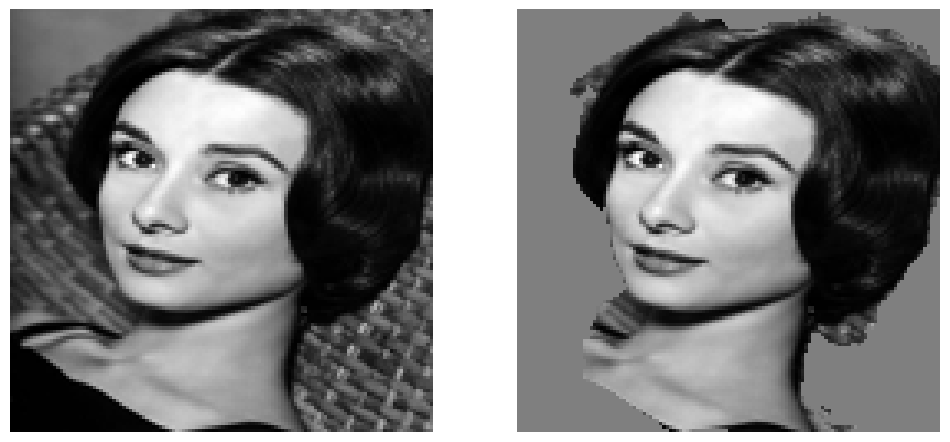

In [53]:
image_path = 'people_segmentation/val/images/audrey-hepburn-actress-breakfast-at-tiffany-s-prominent-76961.jpg'
prediction = predict_one_sample(model, image_path, resize_scale=128)

**Test 2**

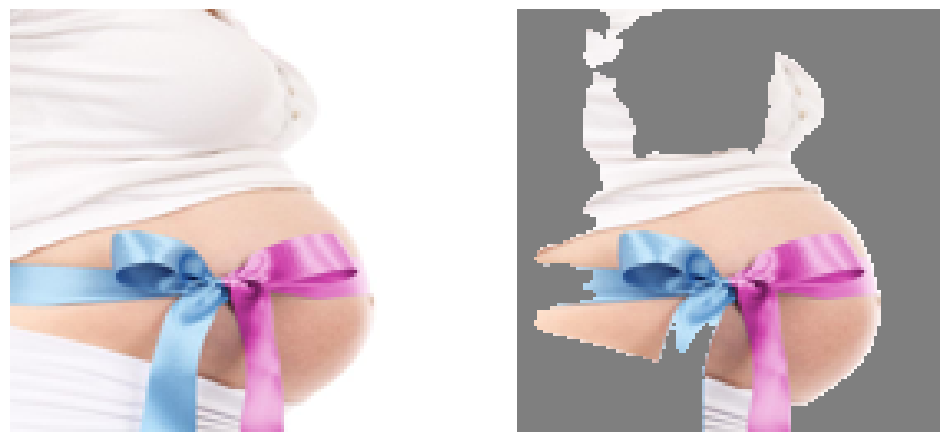

In [54]:
image_path = 'people_segmentation/val/images/girl-baby-belly-blue-41271.jpg'
prediction = predict_one_sample(model, image_path, resize_scale=128)

**Test 3**

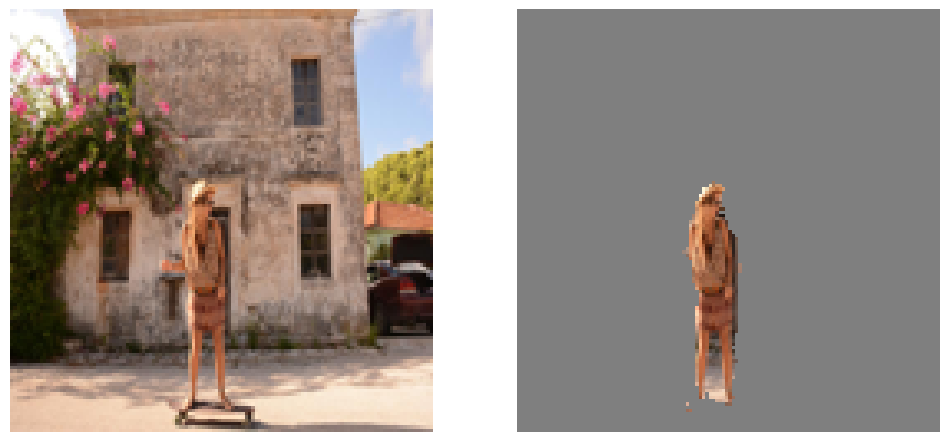

In [55]:
image_path = 'people_segmentation/val/images/pexels-photo-170294.jpg'
prediction = predict_one_sample(model, image_path, resize_scale=128)

**Test 4**

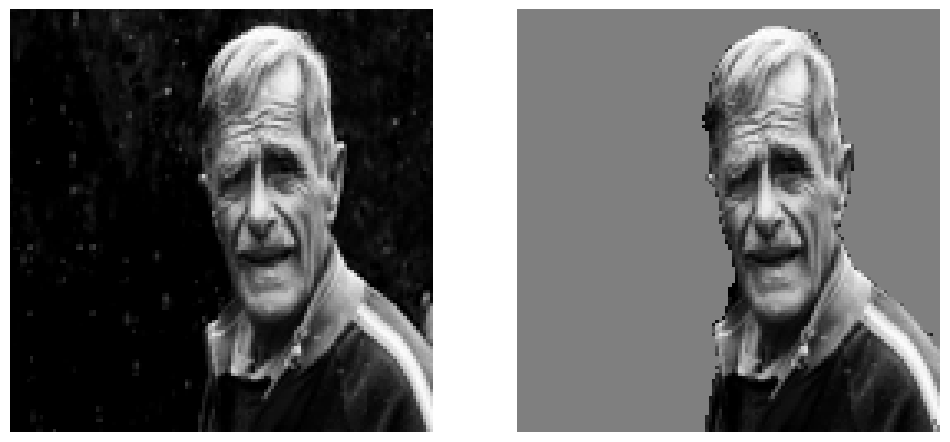

In [56]:
image_path = 'people_segmentation/val/images/pexels-photo-394781.jpg'
prediction = predict_one_sample(model, image_path, resize_scale=128)